# NSSP project 1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes 
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

16:08:13: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:08:13: Debug: Adding duplicate animation handler for '1' type
16:08:13: Debug: Adding duplicate animation handler for '2' type
16:08:13: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:08:13: Debug: Adding duplicate animation handler for '1' type
16:08:13: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:5947): Gtk-CRITICAL **: 16:08:13.736: gtk_window_resize: assertion 'height > 0' failed


In [4]:
#download the dataset

#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset_id= 'ds000171'
subject = 'control01'

#path to save
sample_path = "/home/jovyan/data/NSSP"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dir folder by using the wildcard *
               ], check=True)
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /opt/conda/lib/python3.11/site-packages/openneuro/_cli.py:64 in download_cli │
│                                                                              │
│    61 │   ] = 5,                                                             │
│    62 ) -> None:                                                             │
│    63 │   """Download datasets from OpenNeuro."""                            │
│ ❱  64 │   download(                                                          │
│    65 │   │   dataset=dataset,                                               │
│    66 │   │   tag=tag,                                                       │
│    67 │   │   target_dir=target_dir,                                         │
│                                                                              │
│ ╭─────────────────────────── locals ───────────────────────────╮             │
│ │                  dataset

CalledProcessError: Command '['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/data/NSSP/ds000171', '--include', 'sub-control01/*']' returned non-zero exit status 1.

In [5]:
# explore the dataset folder
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


# Anatomical preprocessing

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:5947): Gdk-WARNING **: 16:09:47.376: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## 1.1 Skull stripping

In [7]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=True):
    """
    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01")

Done with BET.


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [9]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

##  1.2 Tissue Segmentation

In [11]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

fast_target = bet_path 

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] 
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

## 1.3 Anatomical Normalization

In [12]:
from fsl.wrappers import flirt

subject_id = 'control01'
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical
reference = mni_template

#FLIRT Linear
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)

#FNIRT non-linear
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')

transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
ants.image_write(warpedImage, resultAnts)


Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)

# FMRI preprocessing

## 1.1 Volume removal (if necessary)

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz'))

Text(0, 0.5, 'Mean voxel intensity')

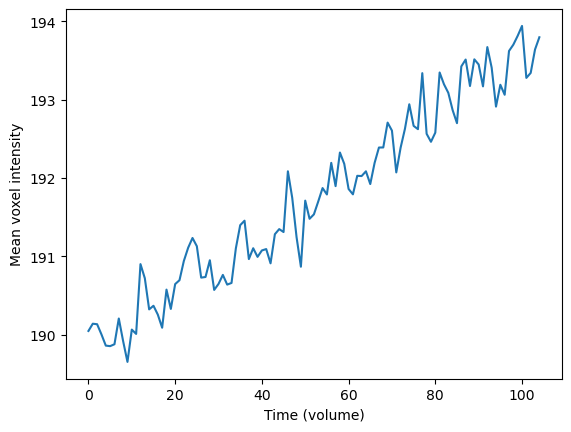

In [15]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
#we see no need of volume removal here

## 1.2 Standardization and concatenation 

In [17]:
import re

func_dir = op.join(bids_root, 'sub-control01', 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_bold\.nii\.gz$')
file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
            mri = nib.load(full_path)
            print(mri.shape)


file_paths.sort()

# Output the array of all runs
print(len(file_paths))
print(file_paths)

(80, 80, 50, 105)
(80, 80, 50, 105)
(80, 80, 50, 105)
3
['/home/jovyan/data/NSSP/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/home/jovyan/data/NSSP/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/home/jovyan/data/NSSP/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz']


In [25]:
def standardization(input_file):
    """
    Apply z-score standardization to fMRI data

    Parameters:
    input_file (str): Path to the input
    output_file (str): Path to save the standardized output 
    """
    # Check if input file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    extract_name = '_'.join(os.path.basename(input_file).split('_')[1:]).rsplit('.', 2)[0]
    print(extract_name)
    output_file = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-{}_{}_standardize.nii'.format(subject,extract_name))
    
    # Load the image data
    img = nib.load(input_file)
    data = img.get_fdata()

    # Calculate global mean and standard deviation
    global_mean = data.mean()
    global_std = data.std()

    # Standardize the data (avoid division by zero)
    standardized_data = (data - global_mean) / global_std if global_std > 0 else data

    # Create a new Nifti image with the standardized data and save
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    nib.save(standardized_img, output_file)

    return output_file

stand_file_paths = []
for file in file_paths :
    stand_file_paths.append(standardization(file))

stand_file_paths

task-music_run-1_bold
task-music_run-2_bold
task-music_run-3_bold


['/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_standardize.nii',
 '/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_standardize.nii',
 '/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_standardize.nii']

In [22]:
fsleyesDisplay.resetOverlays()
for file in stand_file_paths :
    fsleyesDisplay.load(file)

In [26]:
from nilearn.image import concat_imgs, mean_img
concat_path = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-{}_all_task_bold'.format(subject))

fmri_img = concat_imgs(stand_file_paths)
nib.save(fmri_img, concat_path)

## 1.3 Motion Correction 

In [28]:
from fsl.wrappers import mcflirt

path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-{}_all_task_bold_moco'.format(subject))
mcflirt(infile=concat_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][2

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [29]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

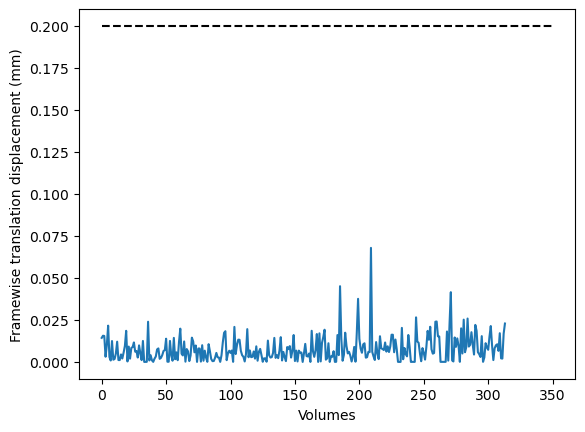

In [31]:
#inspect the translation on X 
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_all_task_bold_moco.par'))

trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 350,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

In [32]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [33]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

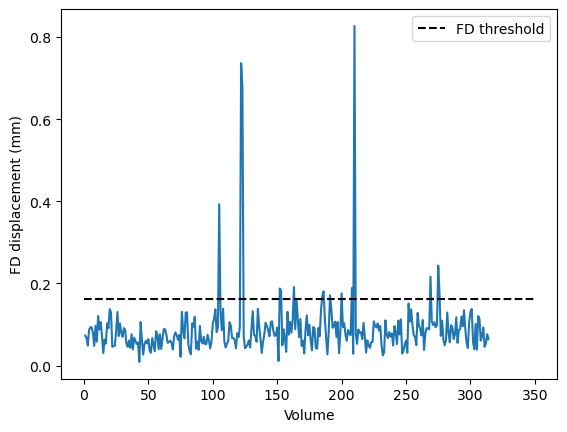

array([105, 122, 123, 152, 153, 163, 165, 185, 186, 191, 200, 208, 210,
       269, 275, 276])

In [35]:
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 350,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

np.where(fd > threshold)[0] + 1 #volumes above threshold that were eliminated in the motion correction process

## 1.4 Coregistration of functional to anatomical

In [76]:
#EPI coregistration
whole_t1 = anatomical_path
skull_stripped_t1 = betted_brain_path
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-{}_all_task_bold_bbr'.format(subject))

ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-{}_all_task_bold_moco_vol_middle'.format(subject))

fslroi(path_moco_data, ref_vol_name, str(157), str(1))

white_matter_segmentation = op.join(preproc_root, 'sub-control01', 'anat', 'sub-{}_T1w_fast_pve_2.nii.gz'.format(subject)) # We provide the white matter segmentation


subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])


FLIRT pre-alignment
Running BBR
Applying POWELL correction
finit, fend, fextrap = 0.285178 , 0.284748 , 0.284508
fval = 0.284445
0.284335 0.999535 -0.019461 -0.023494 0.000000 0.019162 0.999734 -0.012871 0.000000 0.023738 0.012415 0.999641 0.000000 -4.899643 4.226287 5.416335 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco_vol_middle', '--t1=/home/jovyan/data/NSSP/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz', '--t1brain=/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w.nii.gz', '--out=/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_bbr', '--wmseg=/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2.nii.gz'], returncode=0)

In [67]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)

In [68]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

## 1.5 Smoothing

In [81]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(path_moco_data, 6/2.3548, path_moco_data)
subprocess.run(['fslmaths',path_moco_data, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(path_moco_data)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco', '-s', '2.547987090198743', '/home/jovyan/data/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_all_task_bold_moco_smoothed-6mm'], returncode=0)

In [82]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data + '_smoothed-6mm')

# GLM

## 1.1 Design Matrix

In [71]:
# Load the event data from each run
events1 = pd.read_csv(op.join(func_dir, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
events2 = pd.read_csv(op.join(func_dir, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
events3 = pd.read_csv(op.join(func_dir, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

#Adjust onset time for run 2 and 3
run1_duration = events1['onset'].max() + events1['duration'].iloc[-1]
run2_duration = events2['onset'].max() + events2['duration'].iloc[-1]

events2['onset'] += run1_duration
events3['onset'] += (run1_duration + run2_duration)

# Concatenate the tables
combined_events = pd.concat([events1, events2, events3], ignore_index=True)

# Save the combined result to a new file or display it
combined_events.to_csv(op.join(func_dir, 'combined_events.tsv'), sep='\t', index=False)
combined_events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [85]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,   #found in task-music_bold.json file 
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm', 
                           drift_model=None, 
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(path_moco_data + '_smoothed-6mm.nii.gz', combined_events)

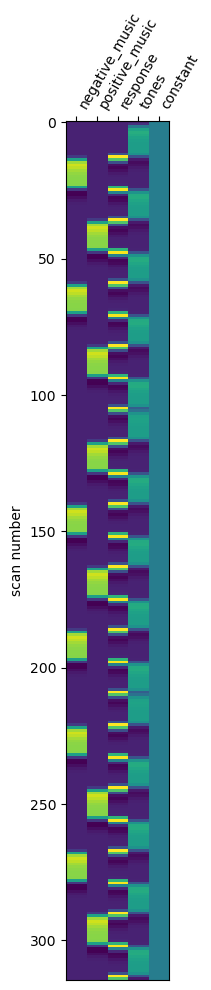

In [86]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [83]:
import nibabel as nib

# Load the NIfTI file
file_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_all_task_bold_moco_smoothed-6mm.nii.gz')
fmri_img = nib.load(file_path)

print(fmri_img.shape)

(80, 80, 50, 315)


In [91]:
conditions = {
    'negative_music': np.array([1,0,0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive_music':np.array([0,1,0,0,0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
    'response':np.array([0,0,1,0,0]),
    'tones':np.array([0,0,0,1,0])
}
posi_min_nega = conditions['positive_music'] - conditions['negative_music']

<Axes: label='conditions'>

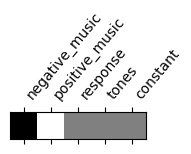

In [92]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(posi_min_nega, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

In [93]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(posi_min_nega,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

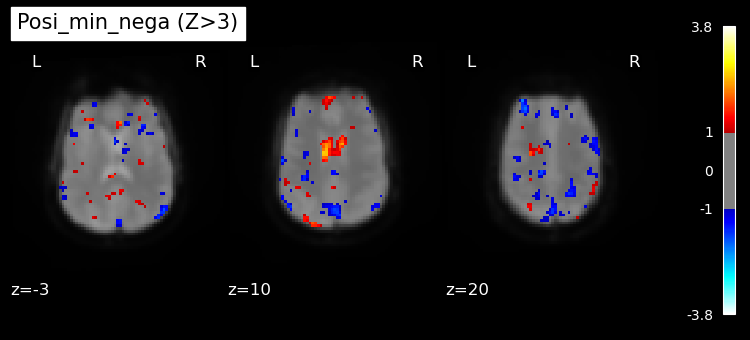

In [113]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=1.0,
              display_mode='z', cut_coords=[-3,10,20], black_bg=True,
              title='Posi_min_nega (Z>3)')
plt.show()